# 0.0. IMPORTS

## 0.1. Libraries

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import umap
import re
import sqlite3
import sqlalchemy

from sqlalchemy          import create_engine
from datetime            import datetime
from matplotlib          import pyplot as plt

from sklearn             import cluster as c
from sklearn             import metrics as mt
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import ensemble as en
from sklearn             import mixture as mx
from sklearn.manifold    import TSNE
from sklearn.neighbors   import NearestNeighbors

from scipy.cluster       import hierarchy as hc

## 0.3. Load Dataset

In [4]:
df = pd.read_csv( '../datasets/data.csv', encoding= 'unicode_escape')

# 1.0. DATA DESCRIPTIONS

In [5]:
df1 = df.copy()

## 1.1. Rename Columns


In [6]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = new_cols

## 1.2. Data Dimension


In [7]:
print( f'Number of columns: {df1.shape[1]}' )
print( f'Number of rows: {df1.shape[0]}' )

Number of columns: 8
Number of rows: 541909


## 1.3. Data Types


In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA


In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA


In [10]:
df_missing = df1.loc[ df1['customer_id'].isna() , :]
df_not_missing = df1.loc[ ~df1['customer_id'].isna() , :]

In [11]:
# pegar todos invoice_no unicos do df_missing 
df_backup = pd.DataFrame( df_missing['invoice_no'] ).drop_duplicates()

# atribuir para o customer_id um numero acima do maximo existente no dataset completo (18287)
df_backup['customer_id_new'] = np.arange( 19000, len( df_backup) + 19000, 1)

# juntar df_backup com o dataset original
df1 = pd.merge( df1, df_backup, how='left', on='invoice_no' )

# coalesce
df1['customer_id'] = df1['customer_id'].combine_first( df1['customer_id_new'] )

# excluir coluna extra
df1 = df1.drop( columns = ['customer_id_new'] )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
customer_id        0
country            0
dtype: int64

## 1.6. Change Data Types


In [13]:
df1['invoice_date'] = df1['invoice_date'].apply( lambda x: re.search('(\d.+) ', x).group(1) )

df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [14]:
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive Statistics


In [16]:
num_attributes = df1.select_dtypes( include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes


In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.mean() ).T
ct2 = pd.DataFrame( num_attributes.median() ).T

# dispersion - min, max, range, std, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d3 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d4 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2. Categorical Attributes


#### Invoices

In [18]:
# invoice_no with strings
len( cat_attributes.loc[ cat_attributes['invoice_no'].apply( lambda x: bool( re.search( '[^\d]+', x) ) ), 'invoice_no'].drop_duplicates() ) 

3839

#### Stock Code

In [19]:
# stock_code with only### Invoices strings
cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code' ].unique()

# Action:
# Remove all lines with ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# 2.0. FEATURE FILTERING

In [22]:
df2 = df1.copy()

In [23]:
# === numerical attributes ===
df2 = df2.loc[ df2['unit_price'] >= 0.04, :]

# === Categorical attributes ===
df2[ ~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns= 'description', axis=1 )

# map
df2 = df2[ ~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[ ~df2['customer_id'].isin( [16446] ) ]

# quantity
df2_returns = df2.loc[ df2['quantity'] < 0, : ]
df2_purchase = df2.loc[ df2['quantity'] >= 0, : ]

# 3.0. FEATURE ENGINNERING

In [24]:
df3 = df2.copy()
df3_purchase = df2_purchase.copy()
df3_returns = df2_returns.copy()

In [25]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'] , axis=1).drop_duplicates( ignore_index = True )

## 3.1. Gross Revenue

In [26]:
# gross revenue ( faturamento ) = quantity * price
df3_purchase['gross_revenue'] = df3_purchase['quantity'] * df3_purchase['unit_price']

# monetary
df_monetary = df3_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id        0
gross_revenue    215
dtype: int64

## 3.2. Recency

In [27]:
# recency - Last day purchase
df_recency = df3_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, how = 'left', on='customer_id')
df_ref.isna().sum()

customer_id        0
gross_revenue    215
recency_days     215
dtype: int64

## 3.3. Quantity of Invoices

In [28]:
# # quantity
# df_quant = ( df3_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
#                                                                                                  .rename( columns= {'invoice_no': 'qty_invoices'} ) )
# df_ref = pd.merge( df_ref, df_quant, how= 'left', on = 'customer_id' )
# df_ref.isna().sum()

## 3.4. Average Ticket

In [29]:
# # Average Ticket
# df_avg_ticket = df3_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename( columns= {'gross_revenue': 'avg_ticket'})
# df_ref = pd.merge( df_ref, df_avg_ticket, how = 'left', on='customer_id')
# df_ref.isna().sum()

## 3.5. Average Recency Days

In [30]:
# # average recency days
# df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending= [False, False] )
# df_aux['next_customer_id'] = df_aux['customer_id'].shift()
# df_aux['next_date'] = df_aux['invoice_date'].shift()

# df_aux['avg_recency_days'] = ( df_aux.apply( lambda x: (x['next_date'] - x['invoice_date']).days if 
#                                                         x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 ) )

# df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'next_date'], axis=1).dropna()

# # average recency days
# df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# # merge
# df_ref = pd.merge( df_ref, df_avg_recency_days, how='left', on='customer_id')

# df_ref.isna().sum()

## 3.6. Frequency Purchase

In [28]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                                      .agg( max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_ = ('invoice_date', lambda x: ( ( x.max() - x.min() ).days ) +1 ),
                                                                           buy_ = ('invoice_no', 'count') ).reset_index() )

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id        0
gross_revenue    215
recency_days     215
frequency        215
dtype: int64

## 3.7. Number of Returns

In [29]:
df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns = {'quantity': 'qty_returns'})

df_returns['qty_returns'] = df_returns['qty_returns'] * (-1)

df_ref = pd.merge( df_ref, df_returns, how= 'left', on='customer_id')
df_ref.loc[ df_ref['qty_returns'].isna() , 'qty_returns'] = 0

df_ref.isna().sum()

customer_id        0
gross_revenue    215
recency_days     215
frequency        215
qty_returns        0
dtype: int64

## 3.8. Basket Size - Quantity of Itens by basket

In [33]:
# df_aux = ( df3_purchase[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
#                                                                   .agg( n_purchase = ('invoice_no', 'nunique'),
#                                                                         n_products = ('quantity', 'sum') ).reset_index() )
# # calculation
# df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# # merge
# df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how= 'left', on='customer_id')
# df_ref.isna().sum()

## 3.9. Unique Basket Size - Quantity of Itens

In [34]:
# df_aux = ( df3_purchase[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
#                                                                     .agg( n_purchase = ('invoice_no', 'nunique'),
#                                                                           n_products = ('stock_code', 'nunique') ).reset_index() )
# # calculation
# df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# # merge
# df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how= 'left', on='customer_id')
# df_ref.isna().sum()

## 3.10. Quantity of Itens

In [35]:
# # quantity
# df_quant_prod = df3_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename( columns = {'quantity': 'qty_itens'})
# df_ref = pd.merge( df_ref, df_quant_prod, how= 'left', on = 'customer_id' )
# df_ref.isna().sum()

## 3.11. Quantity of Products


In [30]:
# quantity
df_quant_prod = df3_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename( columns = {'stock_code': 'qty_products'})
df_ref = pd.merge( df_ref, df_quant_prod, how= 'left', on = 'customer_id' )
df_ref.isna().sum()

customer_id        0
gross_revenue    215
recency_days     215
frequency        215
qty_returns        0
qty_products     215
dtype: int64

In [31]:
df_ref.shape

(5970, 6)

# 4.0. EDA - EXPLORATORY DATA ANALYSIS 

In [32]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
frequency        0
qty_returns      0
qty_products     0
dtype: int64

In [33]:
df4.shape

(5755, 6)

## 4.3. Space Study

In [34]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qty_products', 'frequency', 'qty_returns']

df4_3 = df4[cols_selected].drop( columns= 'customer_id', axis= 1 )

In [37]:
# normalizar os dados
mm = pp.MinMaxScaler()

df4_3['gross_revenue']  = mm.fit_transform( df4_3[['gross_revenue']] )
df4_3['recency_days']   = mm.fit_transform( df4_3[['recency_days']] )
df4_3['frequency']      = mm.fit_transform( df4_3[['frequency']] )
df4_3['qty_returns']    = mm.fit_transform( df4_3[['qty_returns']] )
df4_3['qty_products']   = mm.fit_transform( df4_3[['qty_products']] )

X = df4_3.copy()

### 4.3.1 PCA

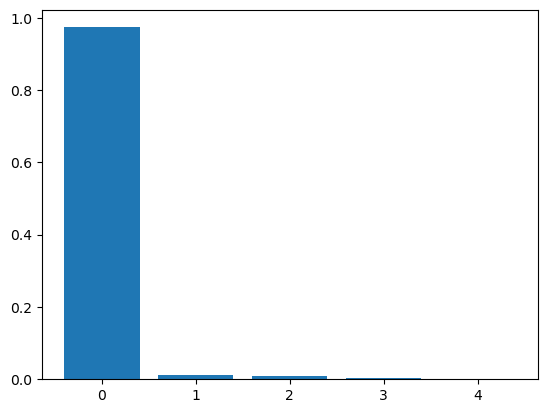

In [39]:
pca = dd.PCA( n_components= X.shape[1])

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( x= features, height = pca.explained_variance_ratio_ );

# PCA component
df_pca = pd.DataFrame( principal_components )

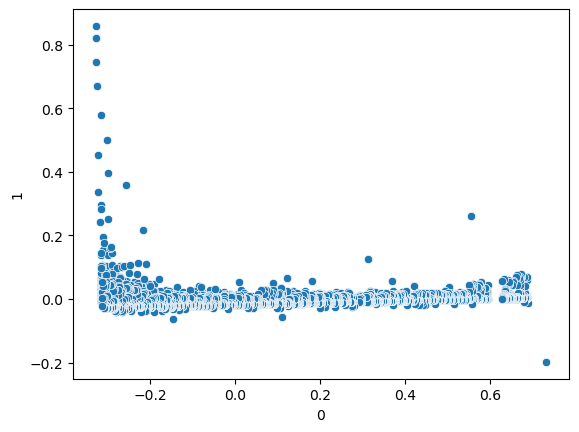

In [40]:
sns.scatterplot( x=0, y=1, data = df_pca);

### 4.3.2. UMAP

In [121]:
reducer = umap.UMAP( n_components= 2, random_state = 42)
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
# sns.scatterplot( x='embedding_x', y='embedding_y', data= df_umap )

### 4.3.3. t-SNE

In [124]:
reducer = TSNE( n_components= 2, n_jobs= -1, random_state = 42)
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot TSNE
sns.scatterplot( x='embedding_x', y='embedding_y', data= df_tsne )

ValueError: n_components=3 must be between 1 and min(n_samples, n_features)=2 with svd_solver='randomized'

### 4.3.4. Tree-Based Embedding

In [164]:
# Training Dataset
X = df4_3.drop( columns= 'gross_revenue', axis=1 )
y = df4_3['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

# Leaf
df_leaf =  pd.DataFrame( rf_model.apply( X ) )

In [165]:
# reducer dimensionality
reducer = umap.UMAP( n_components= 2, random_state = 42)
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
# sns.scatterplot( x='embedding_x', y='embedding_y', data= df_tree )

C:\Users\samue\anaconda3\envs\ds_clusterizacao\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


# 5.0. DATA PREPARATION

In [166]:
# tree-based embedding
df5 = df_tree.copy()

# # UMAP embedding
# df5 = df_umap.copy()
# df5.to_csv( '../datasets/umap_embedding.csv', index= False)

# # TSNE embedding
# df5 = df_tsne.copy()

# 7.0. HYPERPARAMETER FINE-TUNING

In [167]:
X = df5.copy()

In [168]:
X.head()

,embedding_x,embedding_y,embedding_z
0,1.461584,2.367123,-7.883694
1,3.750394,5.237528,-10.272902
2,1.629261,2.707426,-8.505456
3,4.841339,-8.519366,-0.688966
4,6.018250,-6.270780,9.418546


In [170]:
clusters = np.arange( 2, 21, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])

## 7.1. K-Means

In [171]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k, n_init=100, random_state= 42 )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

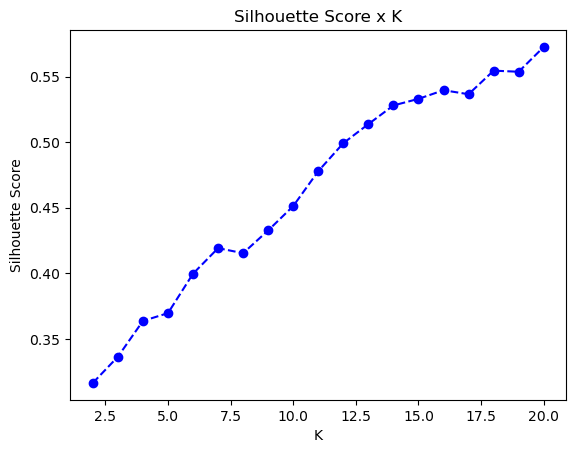

In [172]:
plt.plot( clusters, kmeans_list, linestyle= '--', marker='o', color='b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score');
plt.title( 'Silhouette Score x K');

## 7.2. GMM

In [173]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components= k, n_init=10, random_state= 42)

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric= 'euclidean' )
    gmm_list.append( sil )

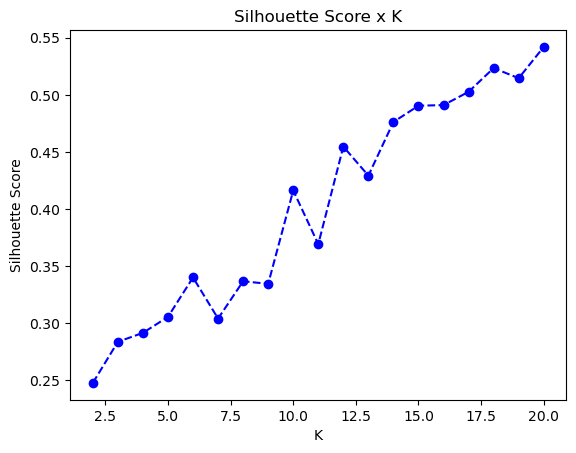

In [174]:
plt.plot( clusters, gmm_list, linestyle='--', marker= 'o', color='b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K');

## 7.3. Hierarchical Clustering


In [175]:
# model definition and training
hc_model = hc.linkage( X, method= 'ward', metric= 'euclidean')

### 7.3.1 Hierarchical Clustering Silhouette Score

In [176]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage( X, method='ward')
    
    # model predict
    labels = hc.fcluster( hc_model, k, criterion= 'maxclust' )
    
    # model performance
    sil = mt.silhouette_score( X, labels, metric= 'euclidean')
    hc_list.append( sil )

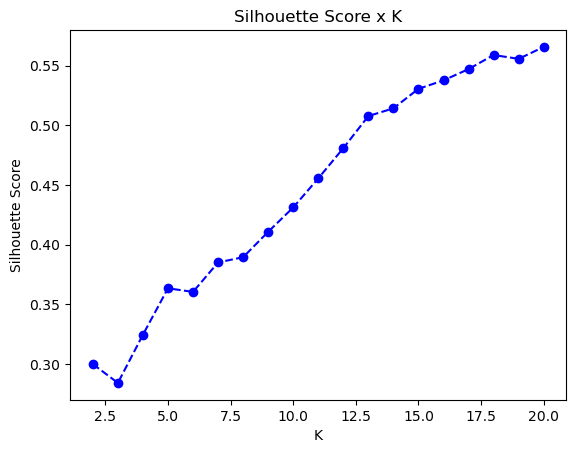

In [177]:
plt.plot( clusters, hc_list, linestyle= '--', marker= 'o', color= 'b');
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.5. Results

In [59]:
# Tree - Based embedding

df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'HClustering': hc_list} ).T

df_results.columns = clusters

df_results.style.highlight_max( color= 'lightgreen', axis= 1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.386090,0.394245,0.403541,0.400799,0.413998,0.411208,0.415312,0.407625,0.418816,0.431671,0.443977,0.454759,0.473288,0.474558,0.487718,0.490833,0.502341,0.501950,0.518154,0.527268,0.523918,0.533831,0.549491,0.553170
GMM,0.385533,0.380982,0.389185,0.403277,0.336989,0.334655,0.239324,0.261337,0.298326,0.277350,0.303286,0.274860,0.278040,0.398385,0.403435,0.398466,0.404108,0.405591,0.409505,0.412045,0.445031,0.432231,0.435708,0.490643
HClustering,0.374922,0.381665,0.364340,0.373366,0.370929,0.375952,0.381294,0.386666,0.389760,0.395466,0.403878,0.416813,0.436367,0.450643,0.457867,0.468772,0.488107,0.496539,0.505796,0.512790,0.521812,0.529991,0.533916,0.541252


In [100]:
# UMAP embedding

df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'HClustering': hc_list} ).T

df_results.columns = clusters

df_results.style.highlight_max( color= 'lightgreen', axis= 1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.411099,0.464726,0.460359,0.459675,0.474745,0.478638,0.504225,0.497027,0.507949,0.518333,0.520799,0.550723,0.555278,0.549071,0.547523,0.555459,0.558763,0.567783,0.559889,0.554924,0.557281,0.552998,0.546107,0.557597
GMM,0.389385,0.462606,0.450233,0.384169,0.314850,0.363190,0.361167,0.342682,0.396124,0.475885,0.500778,0.506266,0.520225,0.501262,0.531825,0.551090,0.539685,0.521539,0.544198,0.548517,0.526972,0.528342,0.515386,0.528937
HClustering,0.381533,0.412168,0.460968,0.463424,0.467856,0.471071,0.480381,0.503561,0.495211,0.507972,0.517338,0.547291,0.549900,0.552310,0.544955,0.552138,0.553573,0.562335,0.567697,0.557116,0.562039,0.554596,0.553991,0.541530


In [85]:
# TSNE embedding

df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'HClustering': hc_list} ).T

df_results.columns = clusters

df_results.style.highlight_max( color= 'lightgreen', axis= 1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.352330,0.392118,0.410423,0.403035,0.418538,0.422014,0.426572,0.431586,0.435886,0.440753,0.443725,0.441349,0.439670,0.448245,0.450222,0.459809,0.461216,0.471261,0.476635,0.482214,0.487765,0.490352,0.490327,0.492015
GMM,0.351366,0.369439,0.379573,0.380591,0.390856,0.368622,0.365697,0.358761,0.323049,0.306191,0.345651,0.343361,0.393718,0.290089,0.380735,0.393905,0.346258,0.406758,0.418003,0.416897,0.413690,0.399183,0.381622,0.422165
HClustering,0.337570,0.364586,0.373409,0.355816,0.382383,0.393440,0.383984,0.398829,0.403318,0.404398,0.400456,0.408349,0.404066,0.417535,0.420815,0.414189,0.415870,0.419461,0.428025,0.435297,0.445389,0.457294,0.462494,0.469682


In [178]:
# Tree - Based embedding 3d

df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM': gmm_list,
    'HClustering': hc_list} ).T

df_results.columns = clusters

df_results.style.highlight_max( color= 'lightgreen', axis= 1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
KMeans,0.316464,0.336412,0.363728,0.369671,0.399742,0.419213,0.415387,0.432743,0.451300,0.477916,0.499261,0.513788,0.528031,0.533045,0.539629,0.536589,0.554545,0.553723,0.572645
GMM,0.247848,0.283851,0.291649,0.305659,0.340148,0.304175,0.336841,0.334583,0.416321,0.369312,0.454723,0.429317,0.476271,0.490509,0.491050,0.502672,0.523448,0.514577,0.541974
HClustering,0.299830,0.284015,0.324404,0.363359,0.360318,0.385022,0.389408,0.410715,0.431139,0.455498,0.480851,0.507750,0.514232,0.530594,0.537671,0.547126,0.558933,0.555718,0.565713


# 8.0. MODEL TRAINING

## 8.1. Model Final

### 8.1.1 KMeans

In [101]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=100, max_iter=300, random_state= 42)

# model training
kmeans.fit( X )

# clustering
labels_kmeans = kmeans.labels_

In [102]:
# WSS
print(f'WSS Value: {kmeans.inertia_}')

# SS
print(f'SS Value: { mt.silhouette_score( X, labels_kmeans, metric= "euclidean" ) }' )

WSS Value: 80667.7578125
SS Value: 0.4578169584274292


# 9.0. CLUSTER ANALYSIS

In [108]:
df9_2 = df4[cols_selected].copy()
df9_2['cluster'] = labels_kmeans
df9_2.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,4
1,13047,3237.54,31.0,172.0,0.029155,36.0,0
2,12583,7281.38,2.0,247.0,0.040323,51.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,1
4,15100,876.00,333.0,3.0,0.073171,22.0,4


In [109]:
df9_2.dtypes

customer_id        int64
gross_revenue    float64
recency_days     float64
qty_products     float64
frequency        float64
qty_returns      float64
cluster            int32
dtype: object

In [110]:
df9_2['recency_days'] = df9_2['recency_days'].astype( 'int64' )
df9_2['qty_products'] = df9_2['qty_products'].astype( 'int64' )
df9_2['qty_returns'] = df9_2['qty_returns'].astype( 'int64' )
df9_2['cluster'] = df9_2['cluster'].astype( 'int64' )

In [111]:
# Number of customers
df_cluster = df9_2[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() ) * 100

# Average Gross Revenue
df_avg_gross_revenue = df9_2[['cluster', 'gross_revenue']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how= 'inner', on='cluster' )

# Average Recency Days
df_avg_recency = df9_2[['cluster', 'recency_days']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency, how='inner', on = 'cluster')

# Average products
df_products = df9_2[['cluster', 'qty_products']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_products, how='inner', on = 'cluster')

# Average Frequency
df_frequency = df9_2[['cluster', 'frequency']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on = 'cluster')

# Average returns
df_returns = df9_2[['cluster', 'qty_returns']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, how='inner', on = 'cluster')

In [112]:
df_cluster.sort_values( 'gross_revenue', ascending= False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,qty_returns
3,3,1122,19.496090,4821.490463,8.362745,198.205882,0.310708,55.682709
0,0,1030,17.897480,1918.042126,29.118447,109.238835,0.032374,16.478641
1,1,670,11.642050,1331.070015,93.855224,68.586567,0.028801,10.307463
4,4,611,10.616855,1171.593993,302.397709,66.378069,0.634947,145.399345
6,6,631,10.964379,750.852076,102.321712,54.965135,1.015055,1.606973
7,7,481,8.357950,651.675696,59.166320,45.964657,1.063360,6.613306
5,5,493,8.566464,625.523327,194.070994,41.127789,1.020284,4.766734
2,2,717,12.458732,562.871409,276.368201,43.389121,1.014877,1.059972


# 11.0. DEPLOY TO PRODUCTION

## 11.1. Insert into SQLite

In [113]:
df9_2.dtypes

customer_id        int64
gross_revenue    float64
recency_days       int64
qty_products       int64
frequency        float64
qty_returns        int64
cluster            int64
dtype: object

In [115]:
# # connect database
# conn = create_engine( 'sqlite:///insiders_db.sqlite', echo= False )

# # drop table
# query_drop_insiders = """
#     DROP TABLE insiders
# """

# conn.execute( query_drop_insiders )

C:\Users\samue\AppData\Local\Temp\ipykernel_7088\3477800335.py:9: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  conn.execute( query_drop_insiders )


OperationalError: (sqlite3.OperationalError) no such table: insiders
[SQL: 
    DROP TABLE insiders
]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [116]:
# connect database
conn = create_engine( 'sqlite:///insiders_db.sqlite', echo= False )

# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
        customer_id    INTEGER,
        gross_revenue  REAL,
        recency_days   INTEGER,
        qty_products   INTEGER,
        frequency      REAL,
        qty_returns    INTEGER,
        cluster        INTEGER )
"""

conn.execute( query_create_table_insiders )

In [117]:
# insert table
df9_2.to_sql( 'insiders', con= conn, if_exists= 'append', index= False )

5755

In [118]:
# # get query
# query_collect = """
#     SELECT *
#     FROM insiders
# """

# df = pd.read_sql_query( query_collect, conn )
# df.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qty_returns,cluster
0,17850,5391.21,372,297,17.000000,40,4
1,13047,3237.54,31,172,0.029155,36,0
2,12583,7281.38,2,247,0.040323,51,3
3,13748,948.25,95,28,0.017921,0,1
4,15100,876.00,333,3,0.073171,22,4
